In [1]:
!which python; python --version; pwd

/Users/swagatam/miniconda3/envs/sbi/bin/python
Python 3.10.14
/Users/swagatam/Desktop/ws24/sbi/sourcerer-sequential/notebooks


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [3]:
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.title_fontsize'] = 15
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['figure.dpi'] = 250
matplotlib.rcParams['figure.figsize'] = (4,3)
cmap = plt.get_cmap("viridis")

In [4]:
simulator = 'two_moons'

In [5]:
base_path = '../results_sourcerer_low/'
directories = os.listdir(base_path)

folders = [di for di in directories if simulator in di]

txt = 'seq_{S}_{B}_{I}'
runtxt = 'run_{B}_{I}_'
run = 'run_'
# txt.format(S=simulator, B=1200, I=4)

BUDGETS = []
ITERS = []

for name in folders:
    i = int(name.split('_')[-1])
    bud = int(name.split('_')[-2])
    ITERS.append(i)
    BUDGETS.append(bud)

ITERS = sorted(list(set(ITERS)))
BUDGETS = sorted(list(set(BUDGETS)))

BUDGET_TO_ITERS = {k: [] for k in BUDGETS}
for name in folders:
    i = int(name.split('_')[-1])
    bud = int(name.split('_')[-2])
    BUDGET_TO_ITERS[bud].append(i)
    BUDGET_TO_ITERS[bud].sort()


METRICS_NAMES = ['surro_c2sts',
 'source_simu_pf_c2sts',
 'source_surro_pf_c2sts',
 'source_entropies']

In [6]:
BUDGET_TO_ITERS

{1000: [1, 2, 3, 4, 5, 6, 8, 10],
 2000: [1, 2, 3, 4, 5, 6, 8, 10],
 4000: [1, 2, 3, 4, 5, 6, 8, 10]}

In [7]:
BUDGET_TO_ITERS={ 1000: [1, 2, 3, 4, 5, 6, 8, 10],
 2000: [1, 2, 3, 4, 5, 6, 8, 10],
 4000: [1, 2, 3, 4, 5, 6, 8, 10],
 6000: [1, 2, 3, 6],
 8000: [1, 2, 4],
 12000: [1, 2, 3, 4, 6]}

In [16]:
def path_to_csv(sim, b, i):
    if os.path.exists(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'results_df.csv'):
        return base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'results_df.csv'
    else:
        return '../results_sourcerer/'+txt.format(S=sim, B=b, I=i)+'/'+runtxt.format(B=b, I=i)+'results_df.csv'

def path_to_losses(sim, b, i):
    if os.path.exists(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'results_df.csv'):
        train_losses = np.genfromtxt(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'train_losses_surro.csv')
        val_losses = np.genfromtxt(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'val_losses_surro.csv')
        train_losses_source = np.genfromtxt(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'source_training_losses.csv')
    else:
        train_losses = np.genfromtxt('../results_sourcerer/'+txt.format(S=sim, B=b, I=i)+'/'+runtxt.format(B=b, I=i)+'train_losses_surro.csv')
        val_losses = np.genfromtxt('../results_sourcerer/'+txt.format(S=sim, B=b, I=i)+'/'+runtxt.format(B=b, I=i)+'val_losses_surro.csv')
        train_losses_source = np.genfromtxt('../results_sourcerer/'+txt.format(S=sim, B=b, I=i)+'/'+runtxt.format(B=b, I=i)+'source_training_losses.csv')

    return train_losses, val_losses, train_losses_source


def path_to_source_kole(sim, b, i):
    if os.path.exists(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'gt_source_kole.csv'):
        return np.genfromtxt(base_path+txt.format(S=sim, B=b, I=i)+'/'+run+'gt_source_kole.csv')
    else:
        return np.genfromtxt('../results_sourcerer/'+txt.format(S=sim, B=b, I=i)+'/'+runtxt.format(B=b, I=i)+'gt_source_kole.csv')

In [17]:
# simulator = 'two_moons'

# nrows = len(BUDGET_TO_ITERS)
# ncols=4
# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(5*ncols, 4.5), gridspec_kw={'wspace':0.2,'hspace':0.5})

# b=1000
# iters = BUDGET_TO_ITERS[b]
# vals = np.zeros((len(iters), len(METRICS_NAMES)))
# for i, idx in enumerate(iters):
#     print(i, idx)
#     df = pd.read_csv(path_to_csv(simulator, b, idx))[METRICS_NAMES].iloc[-1:]
#     vals[i] = df.values



# for locj in range(ncols):
#     ax = axes[locj]
#     # ax.plot([*iters, b//1000], vals[:, locj], 'o--')
#     ax.plot(iters, vals[:, locj], 'o--')

#     if locj!=ncols-1:
#         ax.set_ylim(0.45, 0.9)
#         ax.axhline(0.5, color='r', ls=':')

#     ax.set_title(f"{simulator}, B: {b}")
#     ax.set_xlabel("# iterations")
#     ax.set_ylabel(METRICS_NAMES[locj])

## two_moons

In [18]:
# simulator='two_moons'
# b=1000; i=8
# np.genfromtxt(base_path+txt.format(S=simulator, B=b, I=i)+'/'+run+'gt_source_kole.csv')

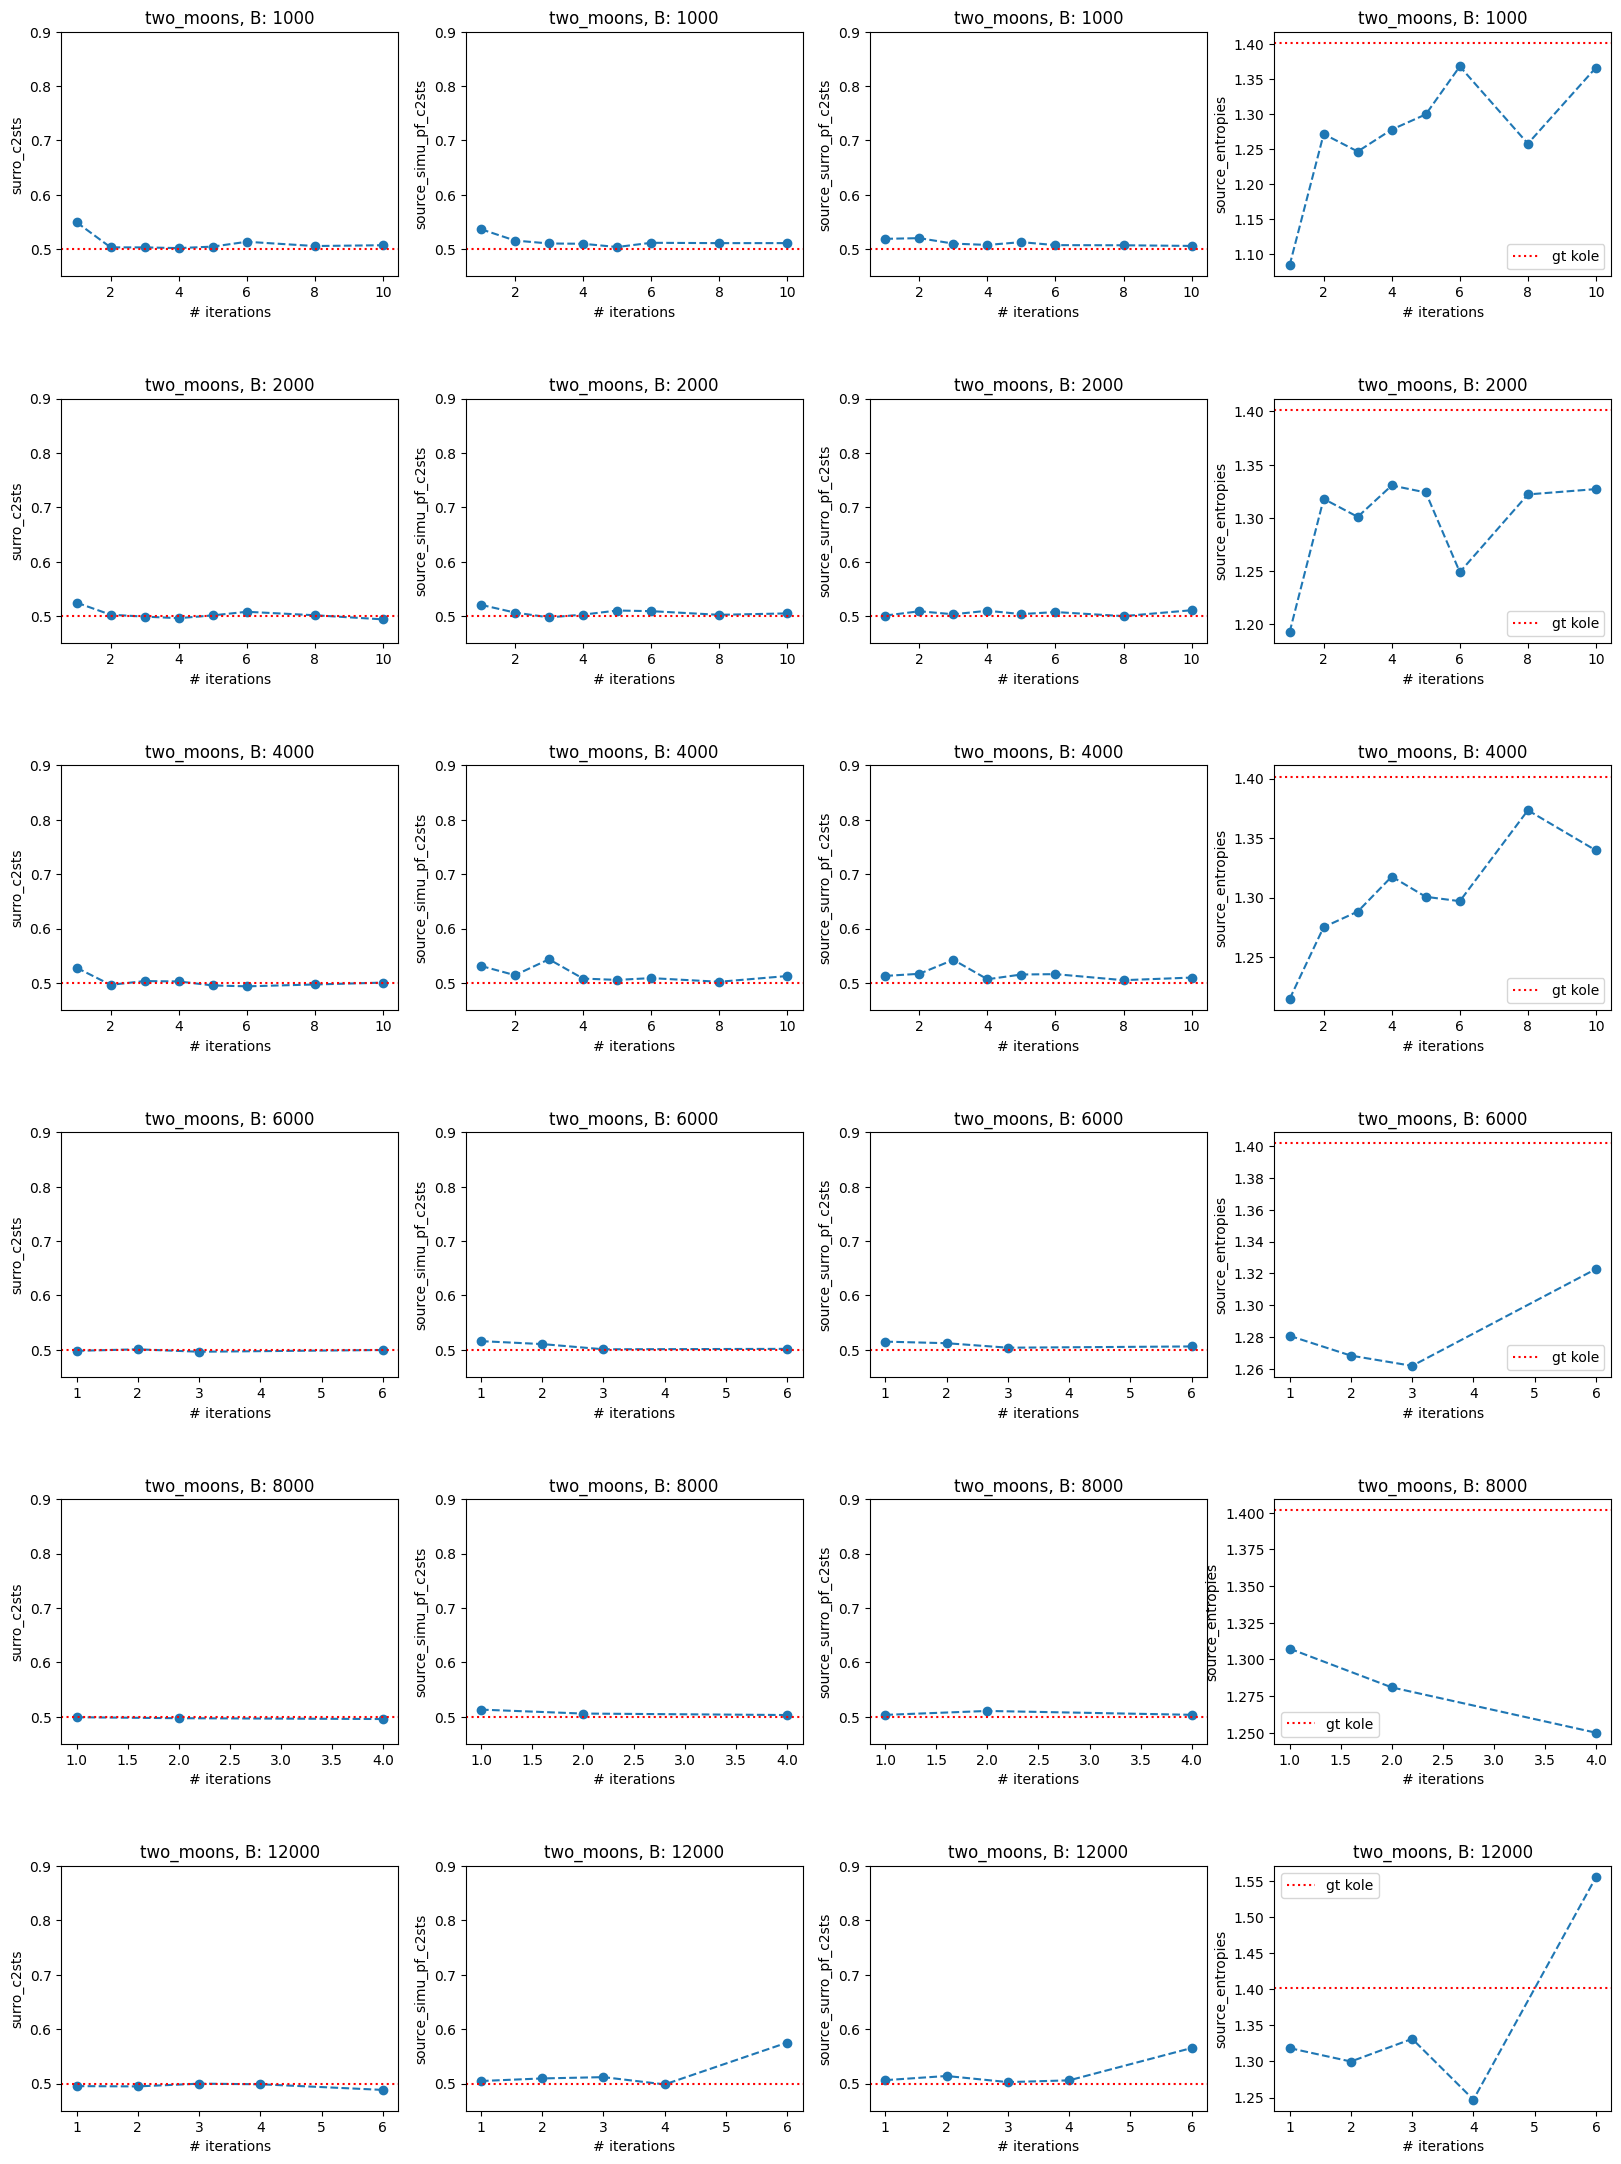

In [36]:
simulator = 'two_moons'

nrows = len(BUDGET_TO_ITERS)
rows = list(BUDGET_TO_ITERS.keys())
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

gt_entropy = None

for loci, b in enumerate(rows):
    #print(loci, b)
    iters = BUDGET_TO_ITERS[b]
    gt_entropy = path_to_source_kole(simulator, b,1)
    vals = np.zeros((len(iters), len(METRICS_NAMES)))
    for i, idx in enumerate(iters):
        #print(i, idx)
        df = pd.read_csv(path_to_csv(simulator, b, idx))[METRICS_NAMES].iloc[-1:]
        vals[i] = df.values
        
        # print(gt_entropy)

    for locj in range(ncols):
        ax = axes[loci, locj]
        ax.plot(iters, vals[:, locj], 'o--')
    
        if locj!=ncols-1:
            ax.set_ylim(0.45, 0.9)
            ax.axhline(0.5, color='r', ls=':')
        else:
            ax.axhline(gt_entropy, color='r', ls=':', label='gt kole')
            ax.legend()
    
        ax.set_title(f"{simulator}, B: {b}")
        ax.set_xlabel("# iterations")
        ax.set_ylabel(METRICS_NAMES[locj])

plt.show()

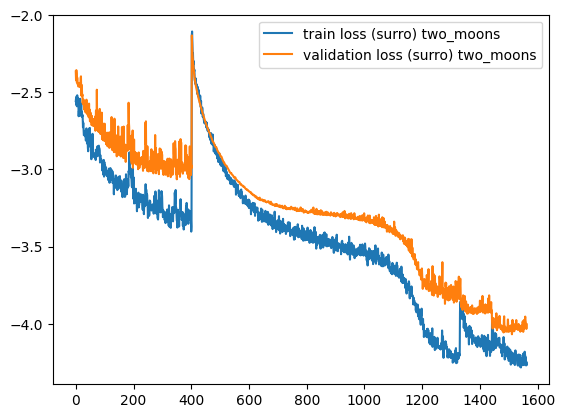

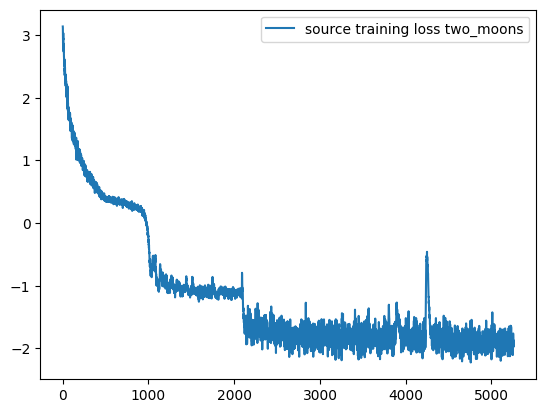

In [21]:
simulator='two_moons'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
train, val, src_train = path_to_losses(simulator, 4000, 4)

start_idx=200
plt.plot(train[start_idx:], label=f"train loss (surro) {simulator}")
plt.plot(val[start_idx:], label=f"validation loss (surro) {simulator}")
plt.legend()
plt.show()


plt.plot(src_train, label=f"source training loss {simulator}"); plt.legend()
plt.show()

## gaussian_mixture
- with fin_lambda=0.35 (forgot to make it 0.062)

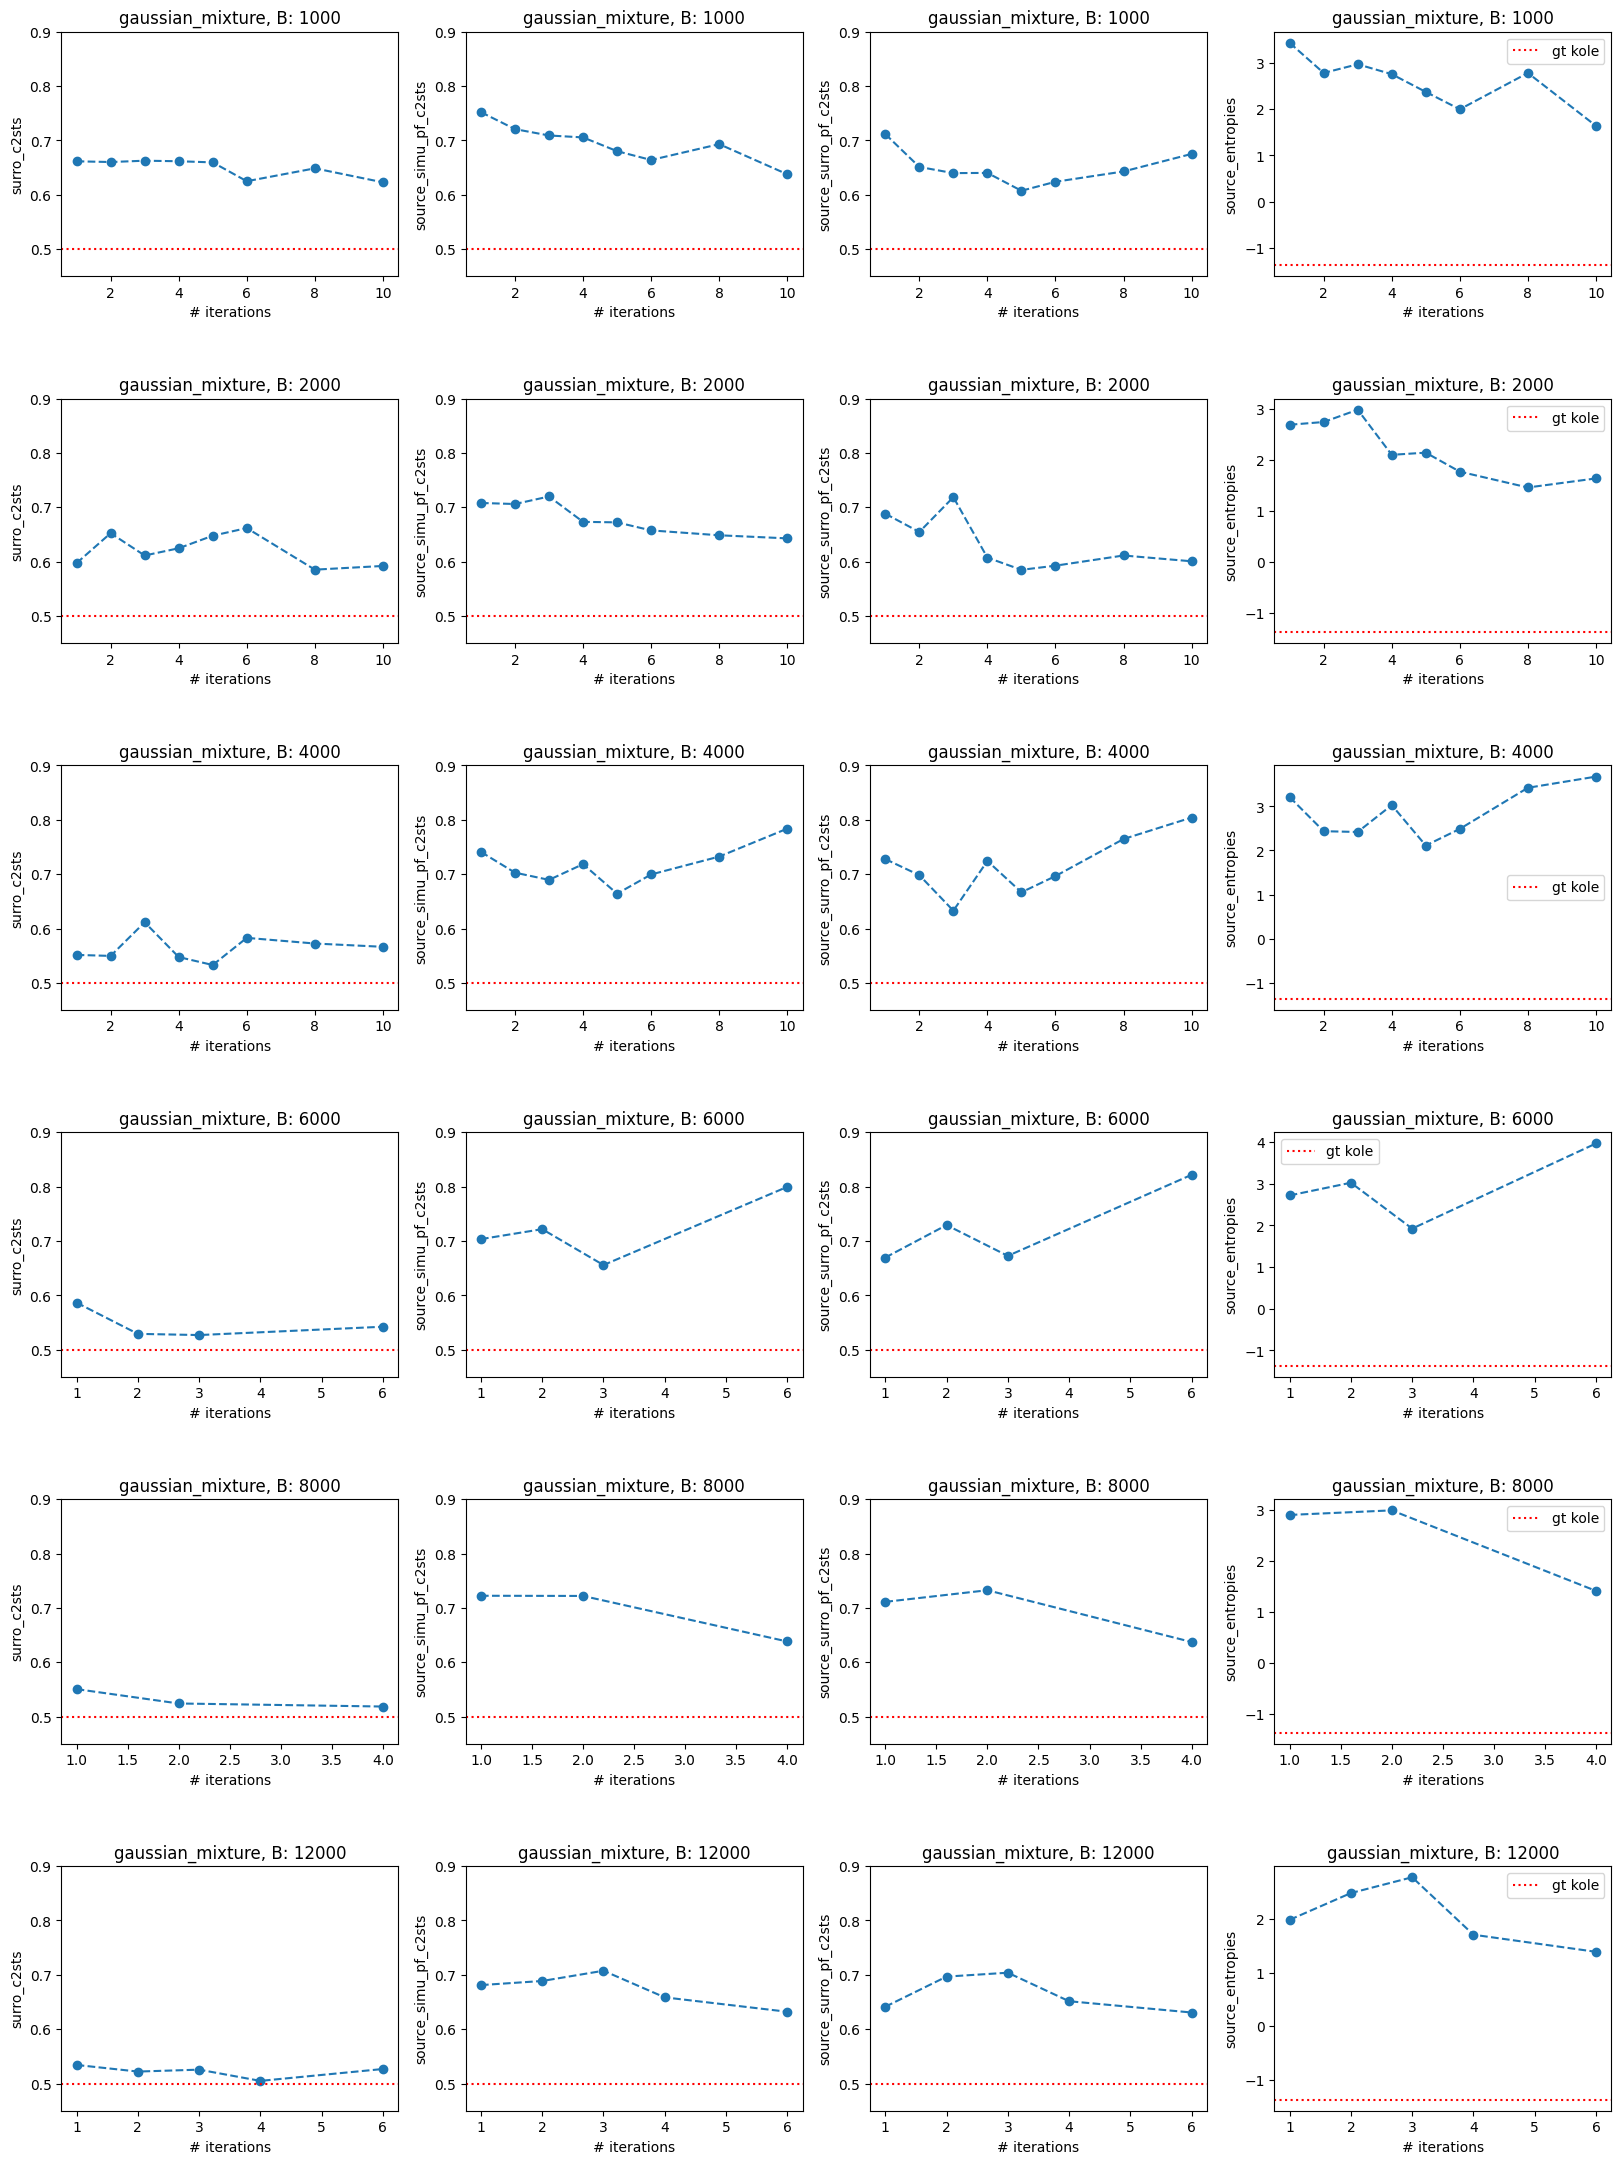

In [35]:
simulator = 'gaussian_mixture'

nrows = len(BUDGET_TO_ITERS)
rows = list(BUDGET_TO_ITERS.keys())
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

gt_entropy = None

for loci, b in enumerate(rows):
    #print(loci, b)
    iters = BUDGET_TO_ITERS[b]
    gt_entropy = path_to_source_kole(simulator, b,1)
    vals = np.zeros((len(iters), len(METRICS_NAMES)))
    for i, idx in enumerate(iters):
        #print(i, idx)
        df = pd.read_csv(path_to_csv(simulator, b, idx))[METRICS_NAMES].iloc[-1:]
        vals[i] = df.values
        
        # print(gt_entropy)

    for locj in range(ncols):
        ax = axes[loci, locj]
        ax.plot(iters, vals[:, locj], 'o--')
    
        if locj!=ncols-1:
            ax.set_ylim(0.45, 0.9)
            ax.axhline(0.5, color='r', ls=':')
        else:
            ax.axhline(gt_entropy, color='r', ls=':', label='gt kole')
            ax.legend()
    
        ax.set_title(f"{simulator}, B: {b}")
        ax.set_xlabel("# iterations")
        ax.set_ylabel(METRICS_NAMES[locj])

plt.show()

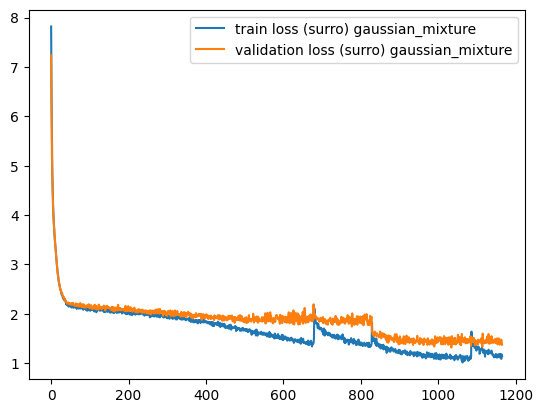

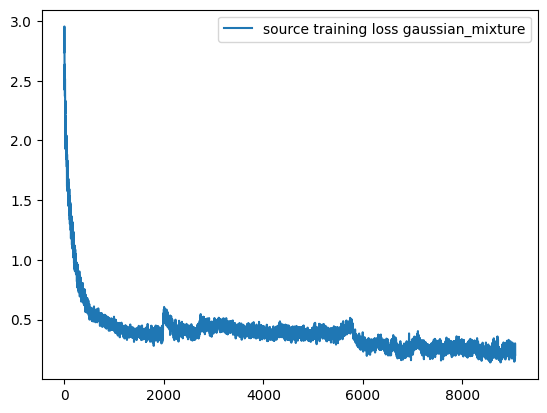

In [26]:

simulator='gaussian_mixture'
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
train, val, src_train = path_to_losses(simulator, 8000, 4)

start_idx=0
plt.plot(train[start_idx:], label=f"train loss (surro) {simulator}")
plt.plot(val[start_idx:], label=f"validation loss (surro) {simulator}")
plt.legend()
plt.show()


plt.plot(src_train, label=f"source training loss {simulator}"); plt.legend()
plt.show()

## inverse kinematics

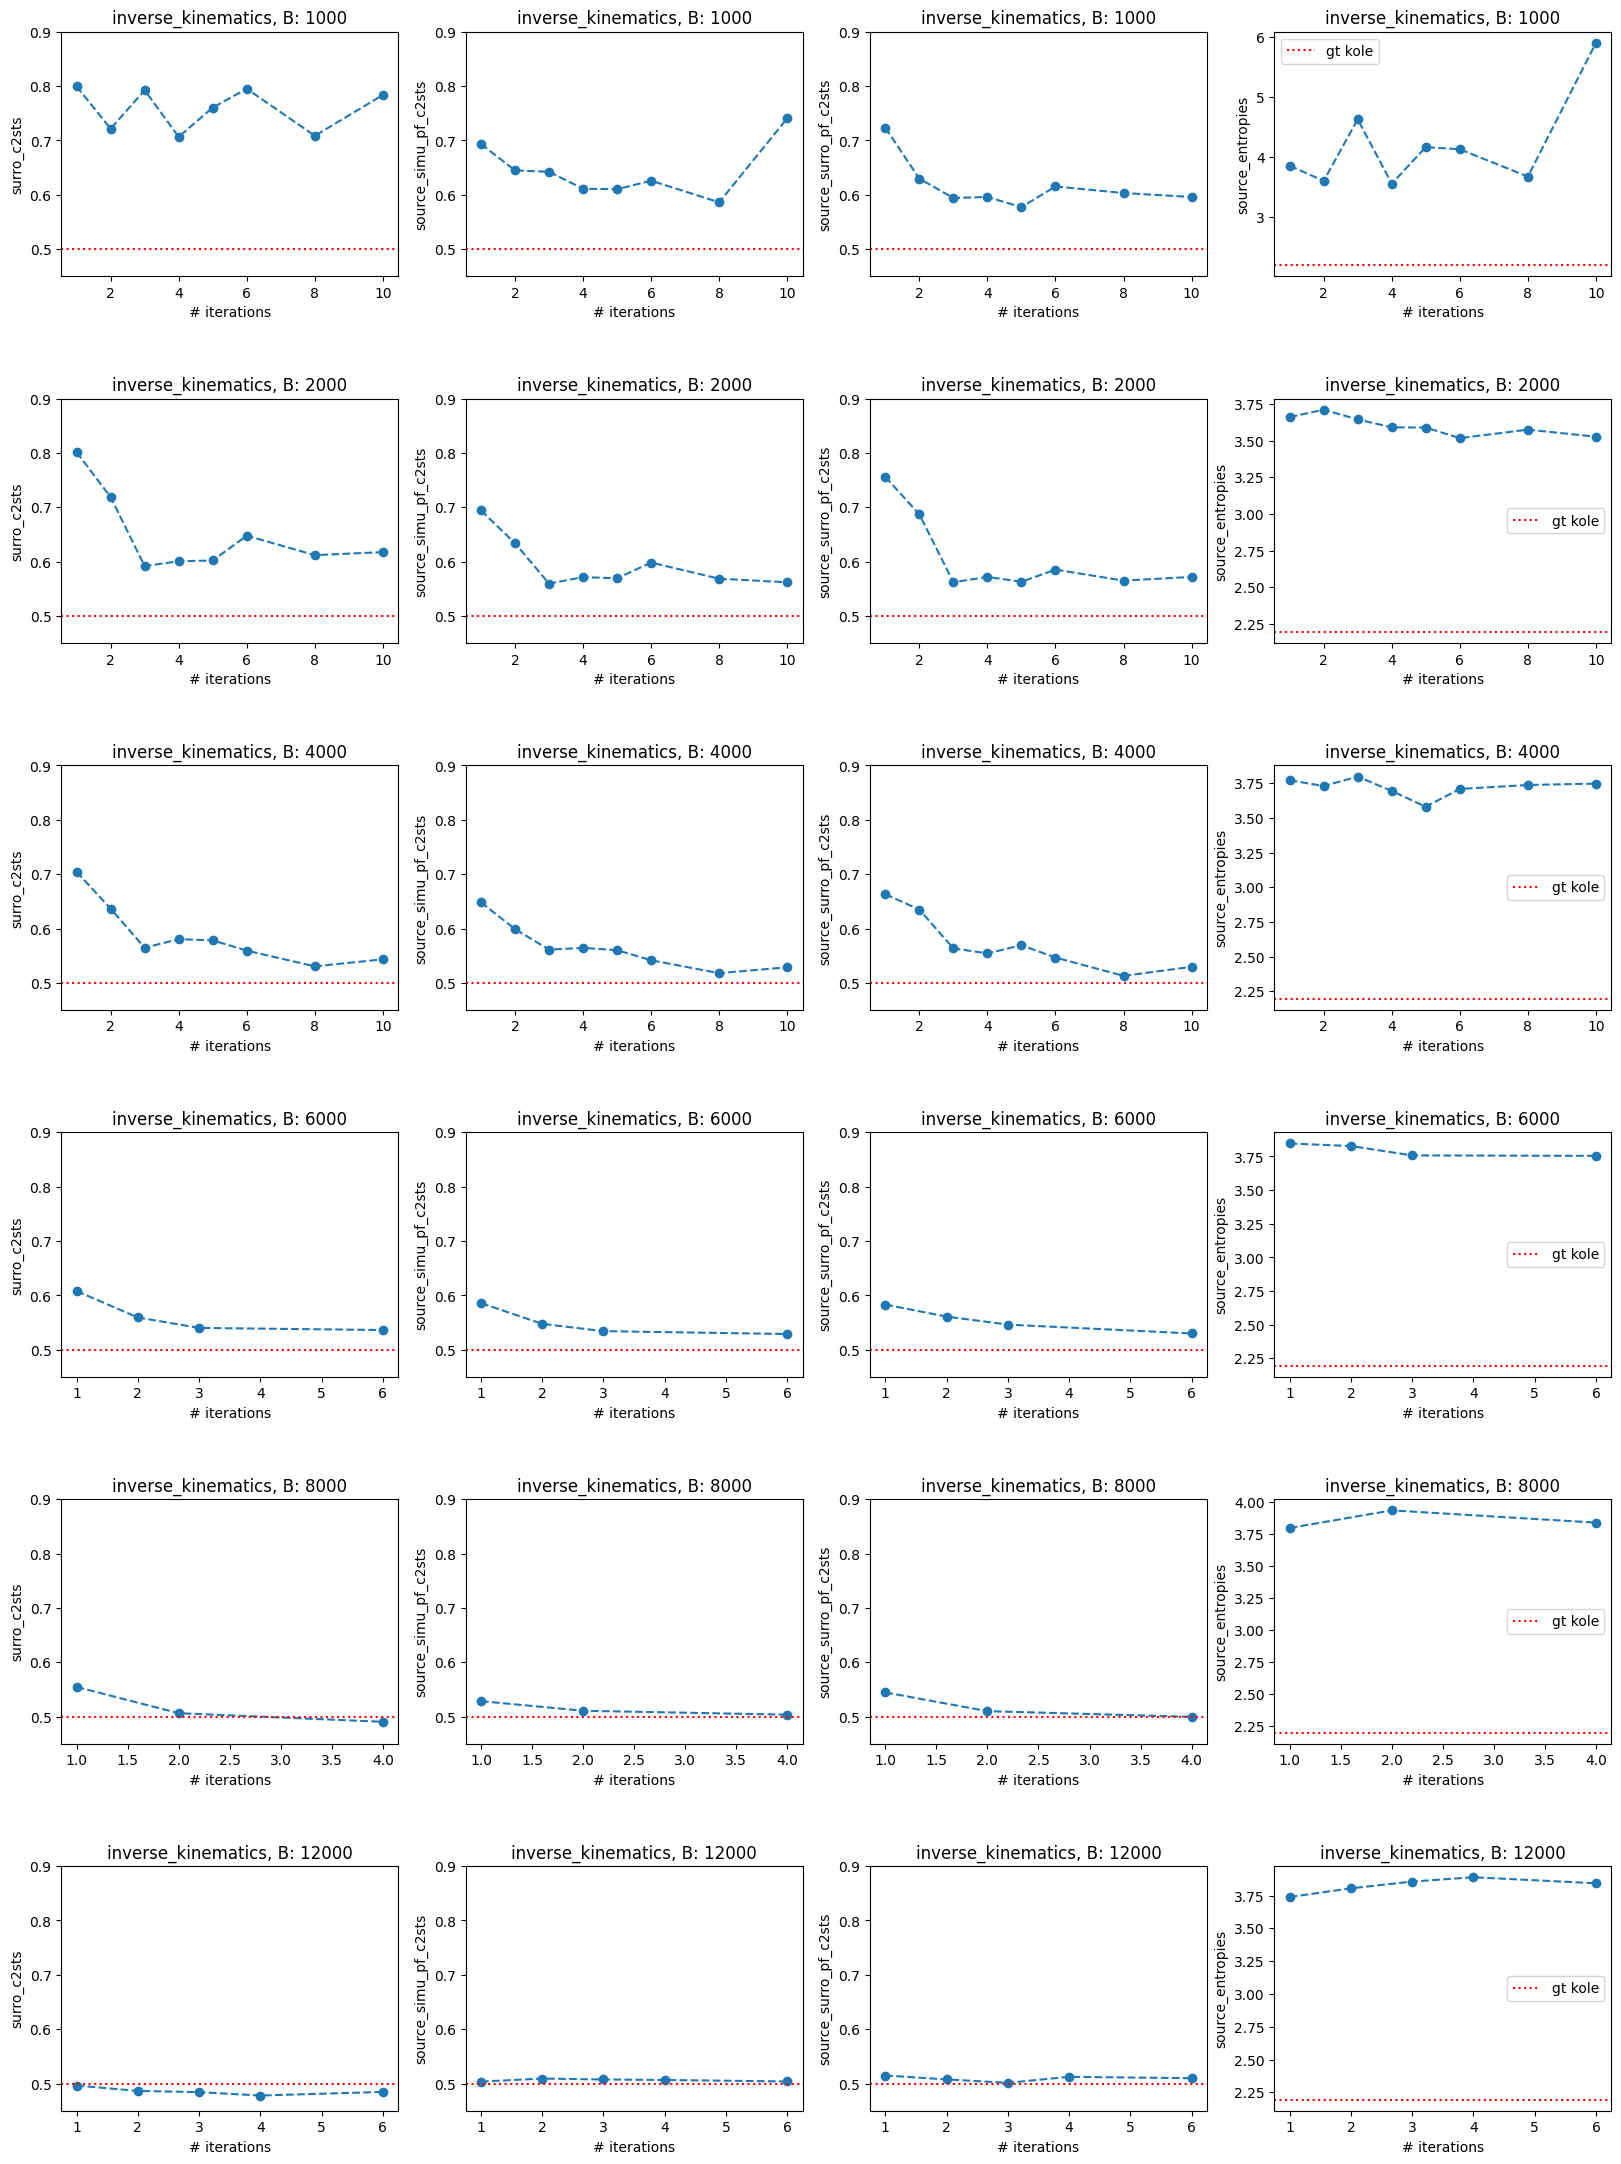

In [33]:
simulator = 'inverse_kinematics'

nrows = len(BUDGET_TO_ITERS)
rows = list(BUDGET_TO_ITERS.keys())
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

gt_entropy = None

for loci, b in enumerate(rows):
    #print(loci, b)
    iters = BUDGET_TO_ITERS[b]
    gt_entropy = path_to_source_kole(simulator, b,1)
    vals = np.zeros((len(iters), len(METRICS_NAMES)))
    for i, idx in enumerate(iters):
        #print(i, idx)
        df = pd.read_csv(path_to_csv(simulator, b, idx))[METRICS_NAMES].iloc[-1:]
        vals[i] = df.values
        
        # print(gt_entropy)

    for locj in range(ncols):
        ax = axes[loci, locj]
        ax.plot(iters, vals[:, locj], 'o--')
    
        if locj!=ncols-1:
            ax.set_ylim(0.45, 0.9)
            ax.axhline(0.5, color='r', ls=':')
        else:
            ax.axhline(gt_entropy, color='r', ls=':', label='gt kole')
            ax.legend()
    
        ax.set_title(f"{simulator}, B: {b}")
        ax.set_xlabel("# iterations")
        ax.set_ylabel(METRICS_NAMES[locj])

plt.show()

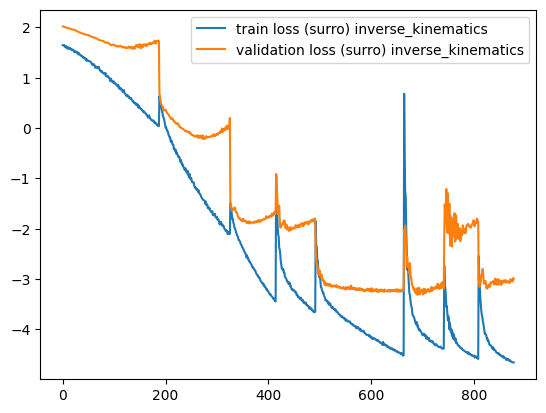

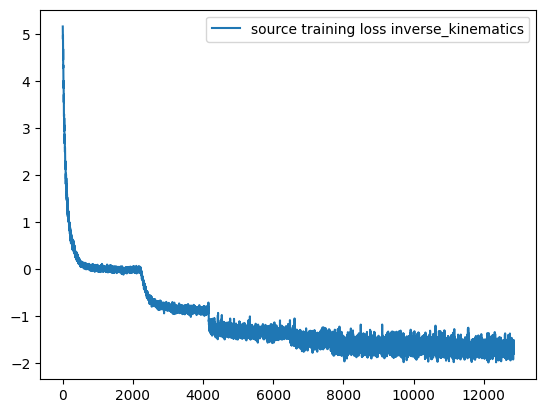

In [28]:

simulator='inverse_kinematics'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
train, val, src_train = path_to_losses(simulator, 4000, 8)

start_idx=200
plt.plot(train[start_idx:], label=f"train loss (surro) {simulator}")
plt.plot(val[start_idx:], label=f"validation loss (surro) {simulator}")
plt.legend()
plt.show()


plt.plot(src_train, label=f"source training loss {simulator}"); plt.legend()
plt.show()

## slcp

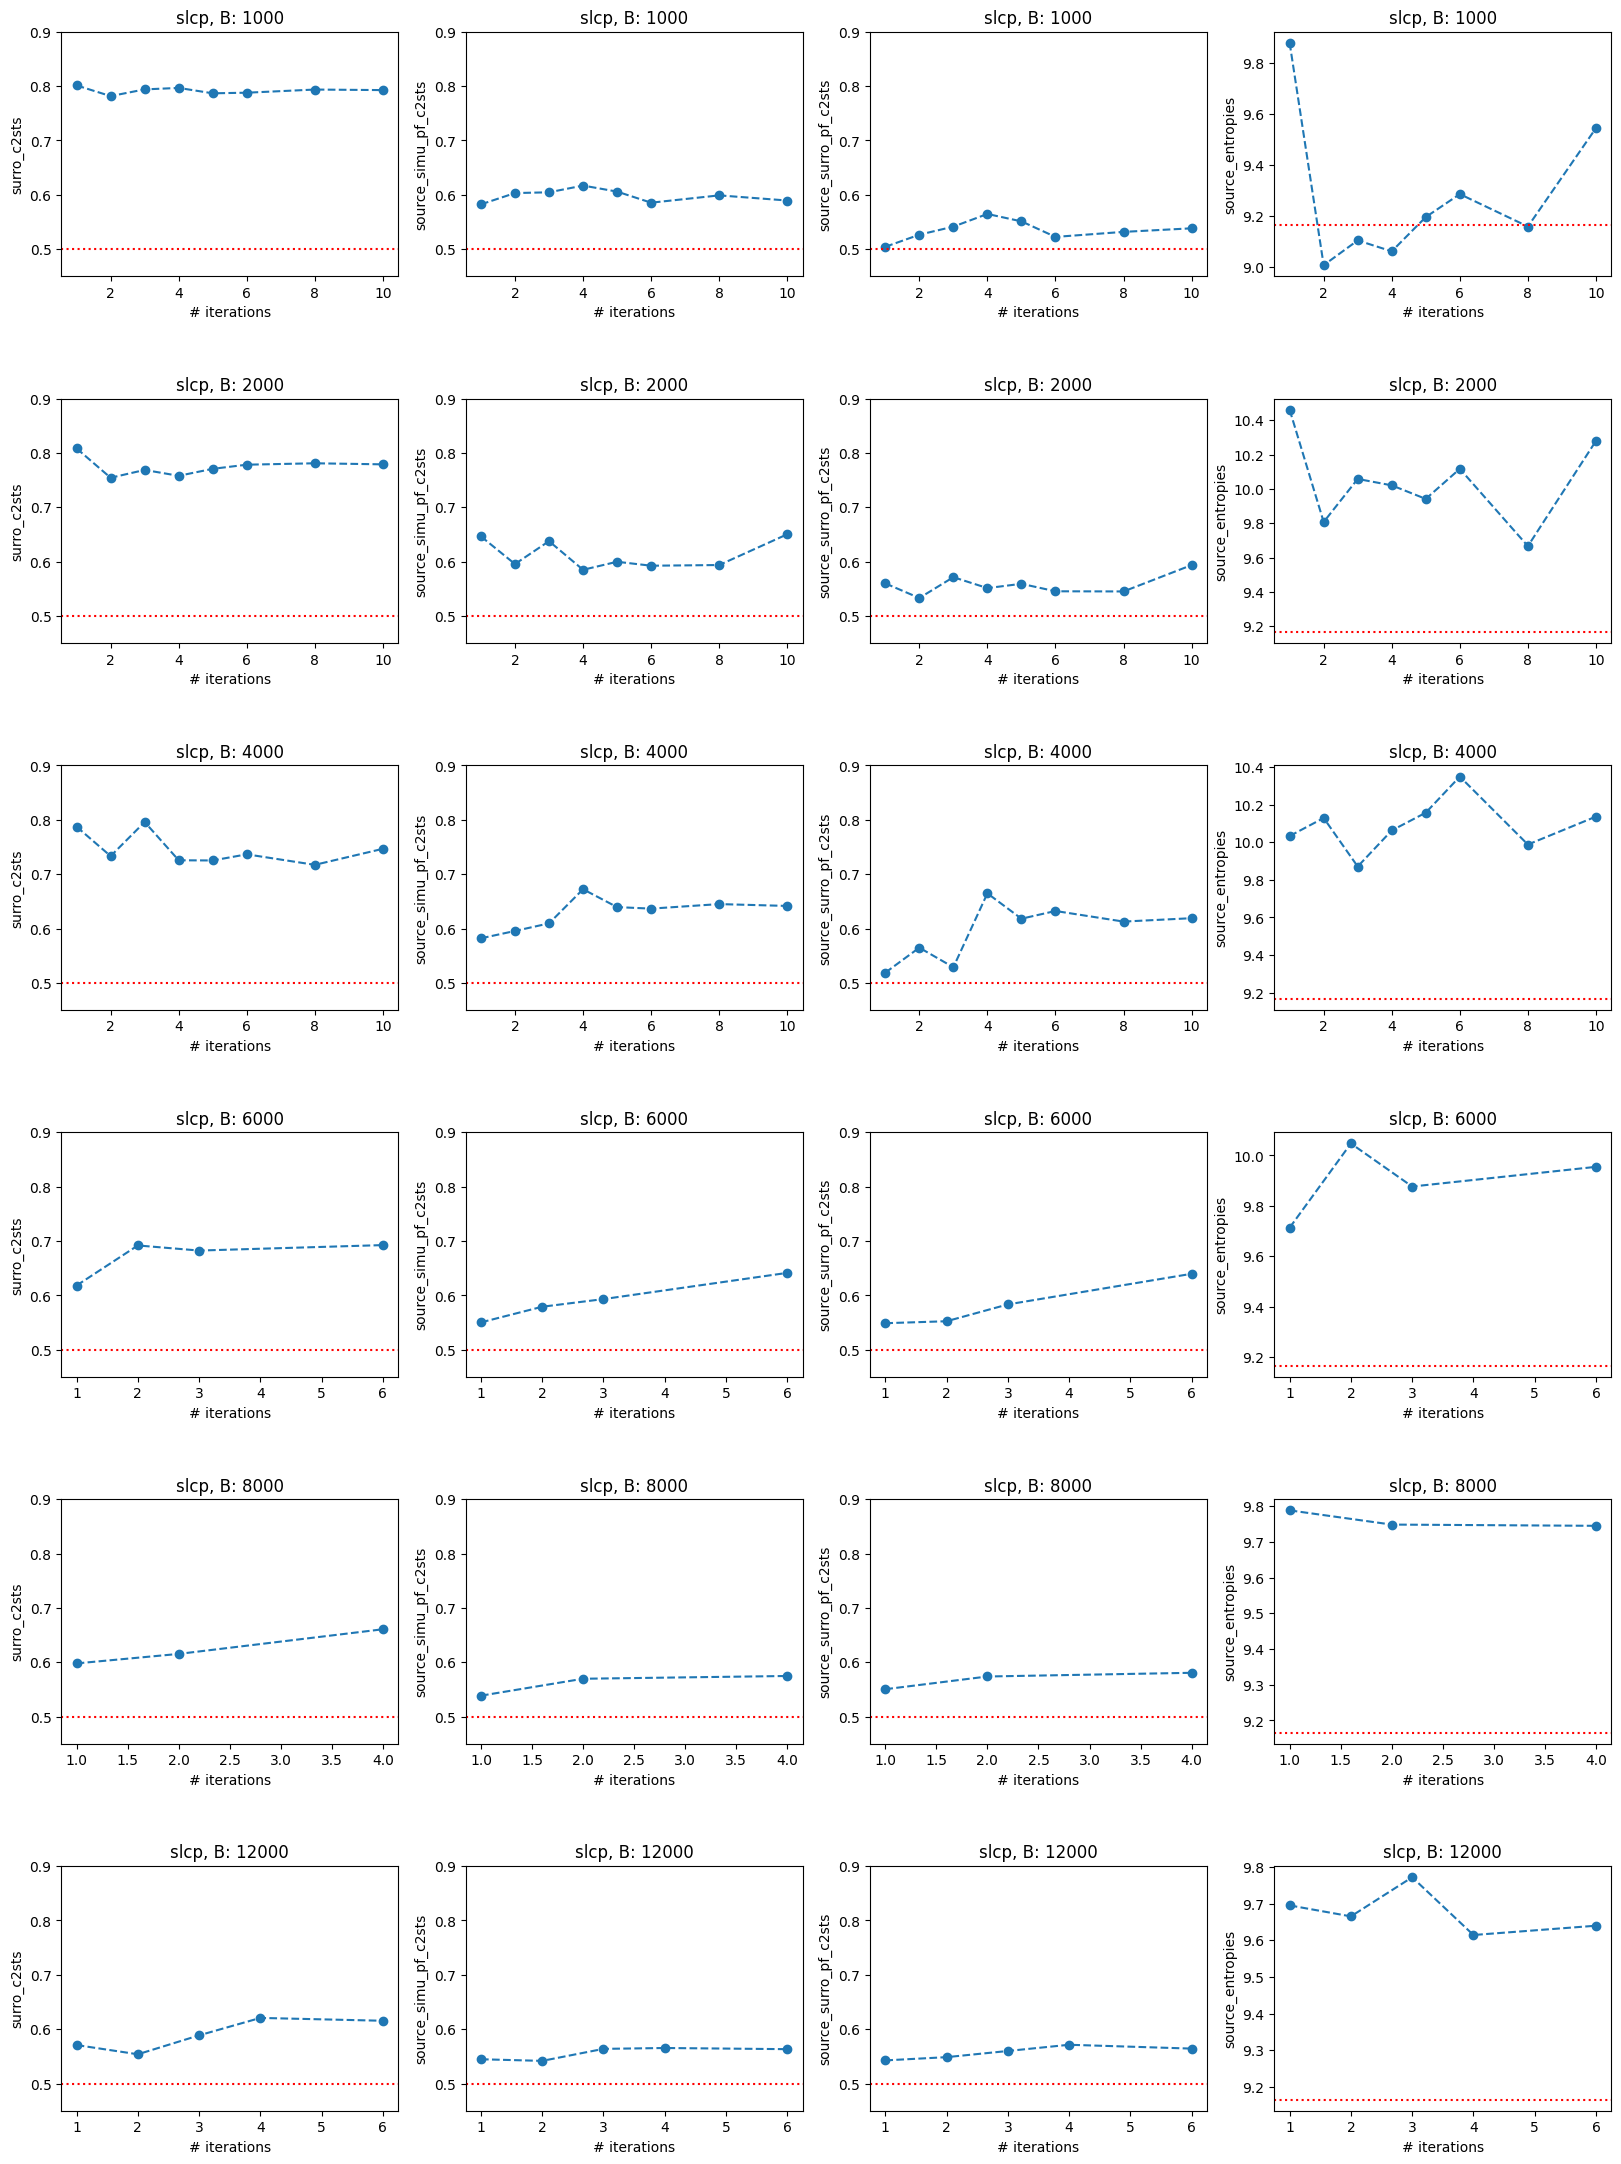

In [29]:
simulator = 'slcp'

nrows = len(BUDGET_TO_ITERS)
rows = list(BUDGET_TO_ITERS.keys())
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

gt_entropy = None

for loci, b in enumerate(rows):
    #print(loci, b)
    iters = BUDGET_TO_ITERS[b]
    gt_entropy = path_to_source_kole(simulator, b, 1)
    vals = np.zeros((len(iters), len(METRICS_NAMES)))
    for i, idx in enumerate(iters):
        #print(i, idx)
        df = pd.read_csv(path_to_csv(simulator, b, idx))[METRICS_NAMES].iloc[-1:]
        vals[i] = df.values
        
        # print(gt_entropy)

    for locj in range(ncols):
        ax = axes[loci, locj]
        ax.plot(iters, vals[:, locj], 'o--')
    
        if locj!=ncols-1:
            ax.set_ylim(0.45, 0.9)
            ax.axhline(0.5, color='r', ls=':')
        else:
            ax.axhline(gt_entropy, color='r', ls=':')
    
        ax.set_title(f"{simulator}, B: {b}")
        ax.set_xlabel("# iterations")
        ax.set_ylabel(METRICS_NAMES[locj])

plt.show()

## loss

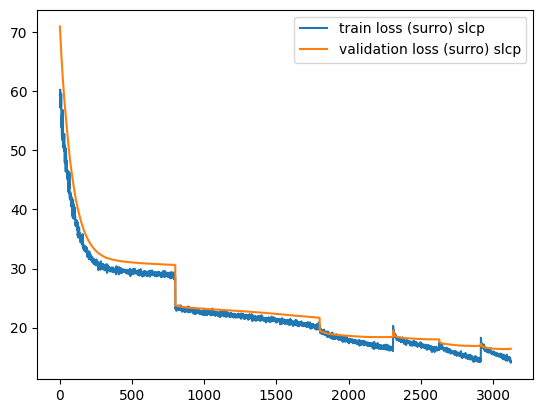

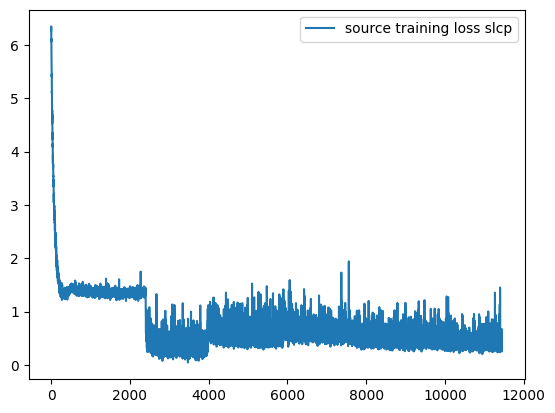

In [30]:
simulator='slcp'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
train, val, src_train = path_to_losses(simulator, 6000, 6)

start_idx=200
plt.plot(train[start_idx:], label=f"train loss (surro) {simulator}")
plt.plot(val[start_idx:], label=f"validation loss (surro) {simulator}")
plt.legend()
plt.show()


plt.plot(src_train, label=f"source training loss {simulator}"); plt.legend()
plt.show()